In [10]:
import numpy as np
from poggers.io import read_fill
from typing import Any
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
#from data.data_getter import LocalFileExplorer
from model.preprocessor import DifferencePreprocessor
#from model.detectors import EnsambleDetector

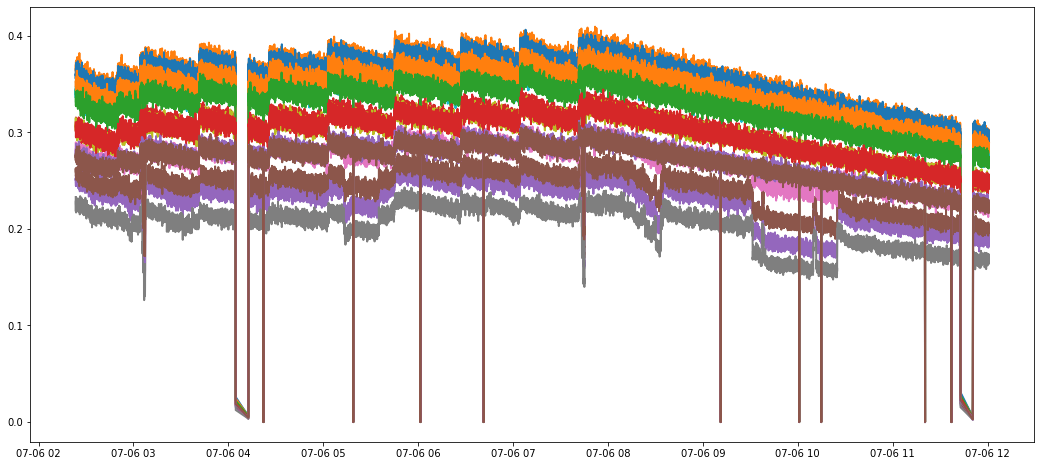

In [34]:
rates_df = read_fill(Path("example_7921_updated"), 7921, "plt", remove_scans=True, index_filter=(0.03,0.97))[1]
rates_df.head()

rates_df.drop(columns = ['avgraw_plt0', 'avgraw_plt1', 'avgraw_plt2',
                         'avgraw_plt3', 'avgraw_plt4', 'avgraw_plt5', 'avgraw_plt6',
                         'avgraw_plt7', 'avgraw_plt8', 'avgraw_plt9', 'avgraw_plt10',
                         'avgraw_plt11', 'avgraw_plt12', 'avgraw_plt13', 'avgraw_plt14',
                         'avgraw_plt15', 'run', 'lsnum'], 
              inplace = True)
rates_df = rates_df.dropna()
rates_df.time = pd.to_datetime(rates_df.time, unit = 's')
rates_df.set_index('time', inplace = True)
rates_df.index.name = None
rates_df = rates_df[np.sum(rates_df, axis = 1) < 11]
rates_df.columns = [i for i in range(16)]

plt.figure(figsize = (18, 8))
for ch in rates_df.columns:
    #processed_diff[ch] = processed_diff[ch] / processed_diff[ch].mean()
    #ax[0].scatter(rates_df[ch].index, rates_df[ch].values, s=4, label=None)
    plt.plot(rates_df[ch].index, rates_df[ch].values, linewidth = 2, label=None)
    #sns.lineplot(data=rates_df[ch], label=ch, ax = ax[0])
    #sns.lineplot(data=processed_diff[ch], label=ch, ax = ax[1])

In [54]:
class Processor:
    def __init__(self):
        self.preprocessor = DifferencePreprocessor()
        #print(mount_path)

    def __call__(self, 
                 parquets_path: str,
                 fill_number: str) -> Any:
        """
        Runs the pipeline

        Args:
            fill_number (int): Fill number
            save_path (str, optional): Where to save the output.
                Defaults to None.
            subsample (int, optional): Subsample rate, in seconds for the data,
                A larger subsample rate will make the pipeline run faster,
                but the results will be less granular.
                Defaults to 5.
            return_preprocessed (bool, optional): If True, returns the
                preprocessed step for visualization. Defaults to False.
            verbose (bool, optional): If True, prints the output
                Defaults to False.
            generate_plots (bool, optional): If True, generates plots for each
                one of the channels and with preprocessing data.
                Defaults to False.

        Returns:
            Any: Output of the pipeline
        """
        attrs, rates_df = read_fill(Path(parquets_path), fill_number, "plt", remove_scans=True, index_filter=(0.05,0.95))
        rates_df.drop(columns = ['avgraw_plt0', 'avgraw_plt1', 'avgraw_plt2',
               'avgraw_plt3', 'avgraw_plt4', 'avgraw_plt5', 'avgraw_plt6',
               'avgraw_plt7', 'avgraw_plt8', 'avgraw_plt9', 'avgraw_plt10',
               'avgraw_plt11', 'avgraw_plt12', 'avgraw_plt13', 'avgraw_plt14',
               'avgraw_plt15', 'run', 'lsnum'], inplace = True)
        rates_df = rates_df.dropna()
        rates_df.time = pd.to_datetime(rates_df.time, unit = 's')
        rates_df.set_index('time', inplace = True)
        rates_df.index.name = None
        rates_df.columns = [i for i in range(16)]
        
        if fill_number == 7921:
            timethreshold = '2022-07-06 03:00:00'
            timethreshold2 = "2022-07-06 11:25:00"
            rates_df = rates_df[np.sum(rates_df, axis = 1) < 11]
            rates_df = rates_df[rates_df.index >= pd.to_datetime(timethreshold)]
            rates_df = rates_df[rates_df.index <= pd.to_datetime(timethreshold2)]

        preprocessed_df = self.preprocess_data(rates_df)
        self.plot_rates_merit_fig(rates_df, preprocessed_df)

        return rates_df
        

    def preprocess_data(self, data: pd.DataFrame) -> pd.DataFrame:
        """
        Studies the fill in the dataframe

        Args:
            data (pd.DataFrame): Dataframe with the data
        """
        dfs = []
        for channel in data.columns:
            dfs.append(self.study_shannel(data, channel, name=channel))
        return pd.concat(dfs, axis=1)

    def study_shannel(
        self, data: pd.DataFrame, studied_channel: int, name="x"
    ) -> pd.DataFrame:
        """
        Studies the channel in the dataframe
        It first add the column "m_agg" to the dataframe, defined as the average of the channels that are not constant (i.e. those channels which less than 90% consecutive equal values)

        Args:
            data (pd.DataFrame): Dataframe with the data
            studied_channel (int): Channel to be studied
            plot (bool, optional): If True, plots the data. Defaults to True.
        """
        df = data.copy()
        df["m_agg"] = df[
            (   #c is a given channel and the for loop returns the list of channels that are not constant. The mean is calculated only from the colums corresponding to these channels.
                c
                for c in self.list_nonconstant_channels(df, studied_channel)
                if c != studied_channel
            )
        ].mean(axis=1)
        X = self.preprocessor(df, ["m_agg", studied_channel]) # ["m_agg", studied_channel] is the list of columns to preprocess
        return self.preprocessor.build_dataframe(df, X, name=name)

    def list_nonconstant_channels(
        self, data: pd.DataFrame, exclude: int = None
    ) -> list:
        """
        Lists the non-constant channels in the dataframe

        Args:
            data (pd.DataFrame): Dataframe with the data

        Returns:
            list: List of the non-constant channels
        """
        are_constant = [
            self._is_constant(c, data)
            for c in data.columns if str(c).isnumeric()
        ]
        if exclude:
            return [
                ch
                for ch, is_constant in zip(data.columns, are_constant)
                if ch != exclude and not is_constant
            ]
        return [ch for ch, c in zip(data.columns, are_constant) if not c]

    def _is_constant(self, channel: int, data: pd.DataFrame) -> bool:
        """
        Checks if the channel is non-constant in the dataframe

        Args:
            channel (int): Channel to be checked
            data (pd.DataFrame): Dataframe with the data

        Returns:
            bool: True if the channel is non-constant, False otherwise
        """
        x = data[channel].values
        diffs = np.diff(x)
        if len(diffs[diffs == 0]) / len(x) > 0.9:
            return True
        return False
        
    def plot_rates_merit_fig(self, 
                             rates_df: pd.DataFrame,
                             processed_diff: pd.DataFrame):
        fig, ax = plt.subplots(2,1, figsize = (18, 8), sharex = True)
        for ch in rates_df.columns:
            processed_diff[ch] = processed_diff[ch] / processed_diff[ch].mean()
            #ax[0].scatter(rates_df[ch].index, rates_df[ch].values, s=4, label=None)
            ax[0].plot(rates_df[ch].index, rates_df[ch].values, linewidth = 2, label=None)
            #sns.lineplot(data=rates_df[ch], label=ch, ax = ax[0])
            sns.lineplot(data=processed_diff[ch], label=ch, ax = ax[1])
        ax[0].set_ylabel('rates')
        ax[1].set_ylabel('Norm. Processed diff.')
        ax[1].set_xlabel(None)

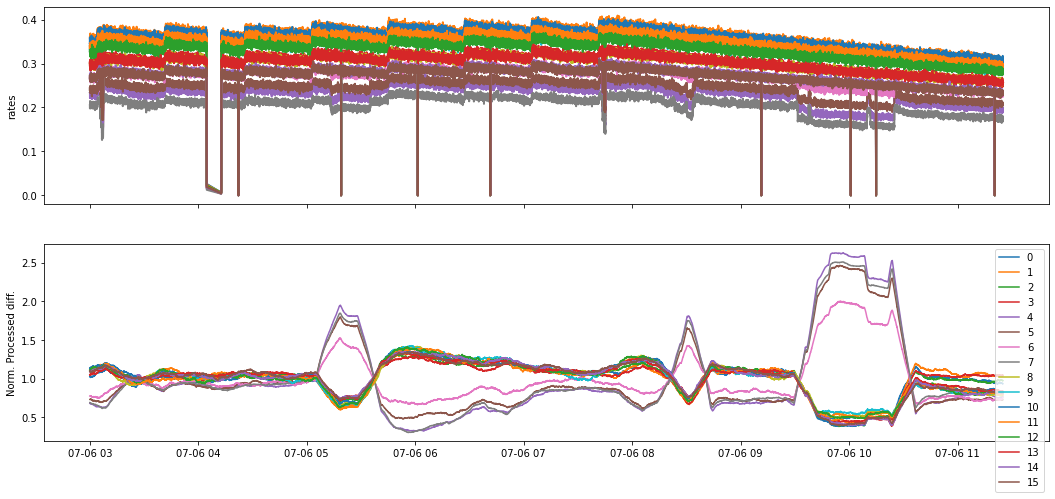

In [55]:
searcher = Processor()
df = searcher("example_7921_updated", 7921)

In [ ]:
df

In [ ]:
df

In [ ]:
complete_df = searcher('/eos/user/t/tatehort/pylaf/parquets_fills/7921_complete.csv')
complete_df

In [ ]:
fig, ax = plt.subplots(2,1, figsize = (18, 8))
for ch in complete_df.columns:
    complete_df[ch] = complete_df[ch]/ complete_df[ch].mean()
    sns.lineplot(data=df[ch], label=ch, ax = ax[0])
    sns.lineplot(data=complete_df[ch], label=ch, ax = ax[1])